<a href="https://colab.research.google.com/github/7865Ayush/Resume_Parser/blob/main/174_resume_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.4 MB/s eta 0:00:00
 File loaded. Here’s the head:
         ID                                         Resume_str  \
0  16852973           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1  22323967           HR SPECIALIST, US HR OPERATIONS      ...   
2  33176873           HR DIRECTOR       Summary      Over 2...   
3  27018550           HR SPECIALIST       Summary    Dedica...   
4  17812897           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  

Shape: (2484, 4)
Columns: ['ID', 'Resume_str', 'Resume_html', 'Category']

Encoded Labels: {'ACCOUNTANT': np.

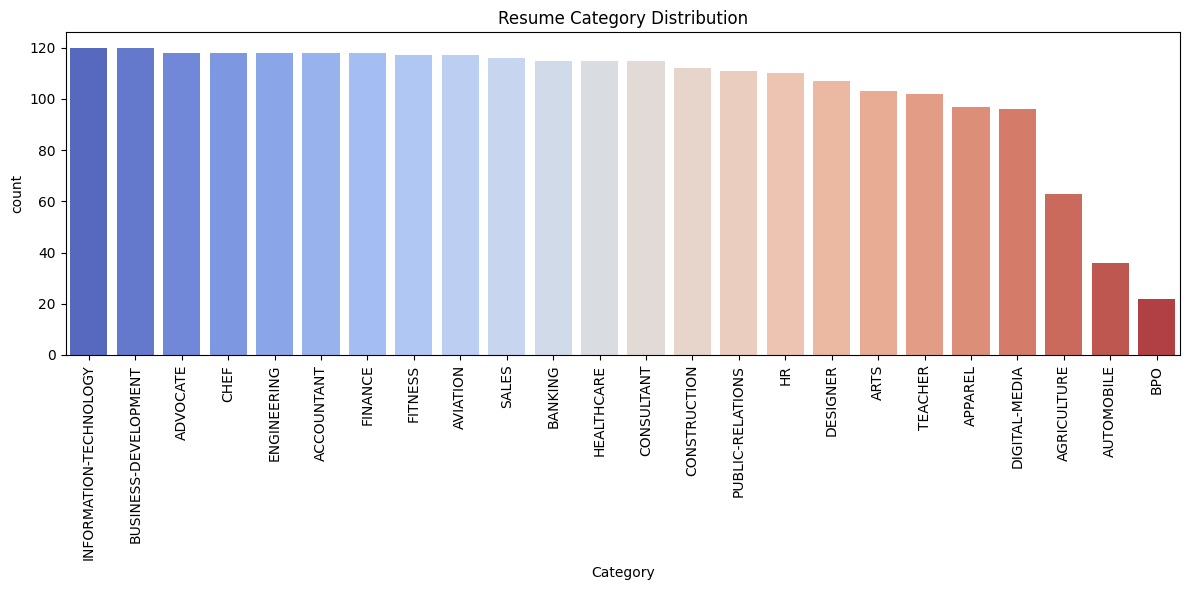

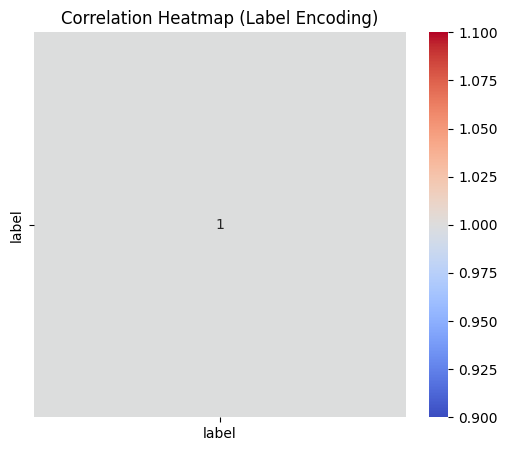

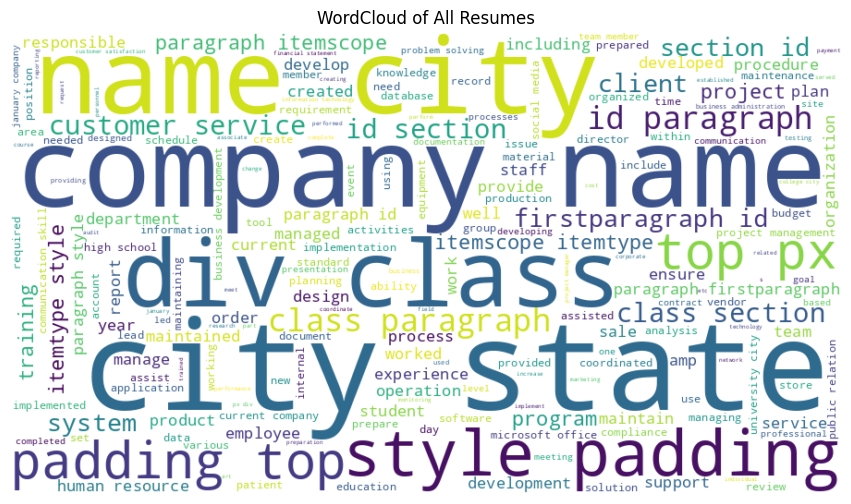

Training samples: 1987, Testing samples: 497

Training Random Forest with SMOTE...

--- MODEL EVALUATION (RF + SMOTE) ---
Accuracy: 0.7626
                        precision    recall  f1-score   support

            ACCOUNTANT       0.66      0.96      0.78        24
              ADVOCATE       0.78      0.75      0.77        24
           AGRICULTURE       0.75      0.46      0.57        13
               APPAREL       0.88      0.37      0.52        19
                  ARTS       0.67      0.19      0.30        21
            AUTOMOBILE       0.67      0.29      0.40         7
              AVIATION       0.81      0.92      0.86        24
               BANKING       0.87      0.57      0.68        23
                   BPO       0.50      0.50      0.50         4
  BUSINESS-DEVELOPMENT       0.96      0.96      0.96        24
                  CHEF       0.79      0.79      0.79        24
          CONSTRUCTION       0.87      0.91      0.89        22
            CONSULTANT      

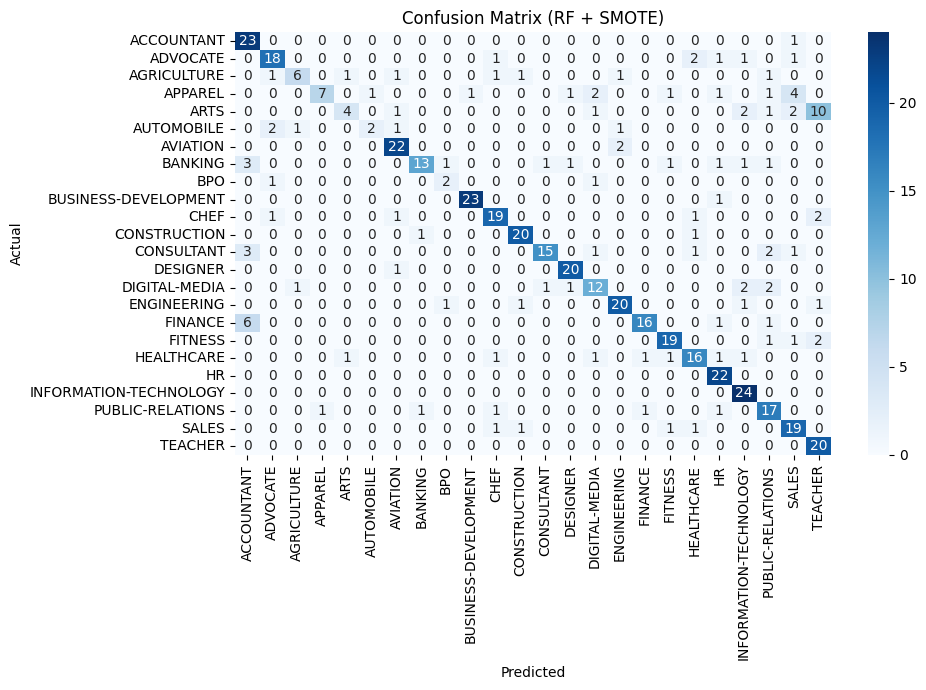


LogReg Cross-Validation Accuracy (Baseline): 0.6412 (+/- 0.0268)


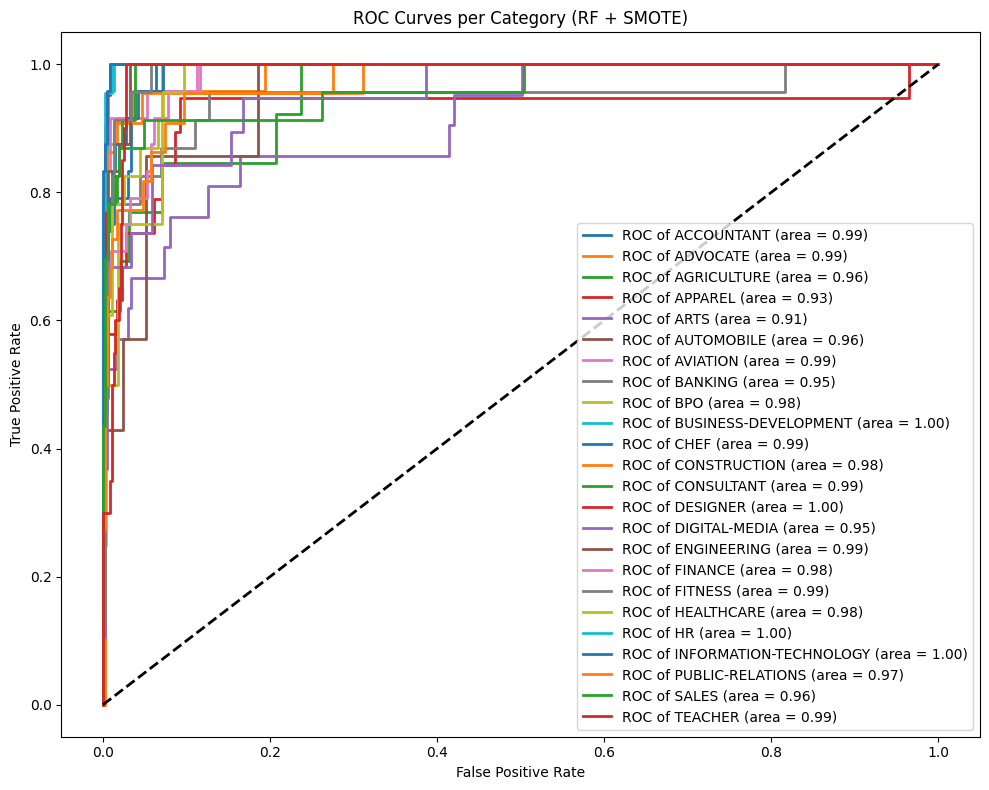

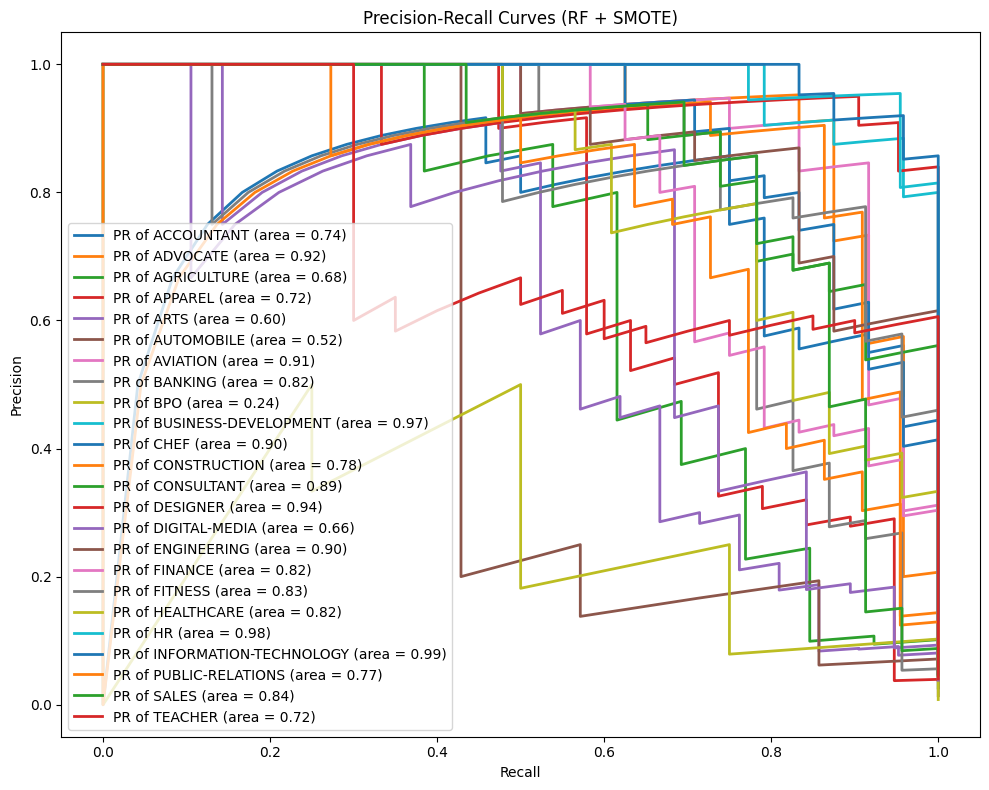


Predicted Category (RF+SMOTE): TEACHER (Confidence: 0.0633)


In [ ]:


# %%
# ================================================================
#  INSTALL & IMPORT LIBRARIES
# ================================================================
!pip install evaluate transformers datasets torch scikit-learn imbalanced-learn wordcloud matplotlib seaborn

import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from itertools import cycle
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import torch
from datasets import Dataset
from evaluate import load
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import warnings
warnings.filterwarnings('ignore')

# %%
# ================================================================
# LOAD DATASET
# ================================================================
# Load from Google Drive link (replace with your own if needed)
drive_link = "https://drive.google.com/file/d/1tUlLUt1JMdKj-FSq7qoKFem5AWji3tuH/view?usp=sharing"
file_id = drive_link.split("/d/")[1].split("/")[0]
download_url = f"https://drive.google.com/uc?id={file_id}"

df = pd.read_csv(download_url)
print(" File loaded. Here’s the head:")
print(df.head())

print("\nShape:", df.shape)
print("Columns:", df.columns.tolist())

# %%
# ================================================================
#  TEXT CLEANING & LABEL ENCODING
# ================================================================
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', str(text))
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Resume_str'] = df['Resume_str'].apply(clean_text)
df['Resume_html'] = df['Resume_html'].apply(clean_text)
df['combined_text'] = df['Resume_str'] + " " + df['Resume_html']

# Label Encoding
le = LabelEncoder()
df['label'] = le.fit_transform(df['Category'])
print("\nEncoded Labels:", dict(zip(le.classes_, le.transform(le.classes_))))

# %%
# ================================================================
#  DATA VISUALIZATION
# ================================================================
# Category Distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index, palette='coolwarm')
plt.title("Resume Category Distribution")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df[['label']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Label Encoding)")
plt.show()

# WordCloud
text_data = " ".join(df['combined_text'])
wordcloud = WordCloud(width=900, height=500, background_color='white').generate(text_data)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of All Resumes")
plt.show()

# %%
# ================================================================
#  RANDOM FOREST + SMOTE
# ================================================================
RANDOM_STATE = 42
TEST_SIZE = 0.2

train_df, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=df['label'], random_state=RANDOM_STATE)

train_texts = train_df['combined_text'].tolist()
test_texts = test_df['combined_text'].tolist()
train_labels = train_df['label'].tolist()
test_labels = test_df['label'].tolist()

print(f"Training samples: {len(train_df)}, Testing samples: {len(test_df)}")

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=7000, ngram_range=(1,2), stop_words='english')
# Random Forest Classifier
classifier = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=RANDOM_STATE, n_jobs=-1)
# Pipeline: TFIDF -> SMOTE -> RF
model = ImbPipeline(steps=[('tfidf', tfidf), ('smote', SMOTE(random_state=RANDOM_STATE)), ('classifier', classifier)])

print("\nTraining Random Forest with SMOTE...")
model.fit(train_texts, train_labels)

# Predictions
y_pred = model.predict(test_texts)
acc = accuracy_score(test_labels, y_pred)
print("\n--- MODEL EVALUATION (RF + SMOTE) ---")
print(f"Accuracy: {acc:.4f}")
print(classification_report(test_labels, y_pred, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test_labels, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix (RF + SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# %%
# Cross-validation & ROC/PR Curves
logreg_model = LogisticRegression(max_iter=400, random_state=RANDOM_STATE)
X_train_vec = tfidf.fit_transform(train_texts)
cv_scores = cross_val_score(logreg_model, X_train_vec, train_labels, cv=5)
print(f"\nLogReg Cross-Validation Accuracy (Baseline): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# ROC & Precision-Recall
n_classes = len(le.classes_)
y_test_bin = label_binarize(test_labels, classes=range(n_classes))
y_score = model.predict_proba(test_texts)

fpr, tpr, roc_auc = {}, {}, {}
precision, recall, pr_auc = {}, {}, {}
colors = cycle(plt.cm.tab10.colors)

plt.figure(figsize=(10,8))
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC of {le.classes_[i]} (area = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves per Category (RF + SMOTE)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
colors = cycle(plt.cm.tab10.colors)
for i, color in zip(range(n_classes), colors):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:,i], y_score[:,i])
    pr_auc[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], color=color, lw=2, label=f"PR of {le.classes_[i]} (area = {pr_auc[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (RF + SMOTE)")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Sample prediction
sample_text = "Experienced data scientist skilled in Python, deep learning, and data visualization."
cleaned = clean_text(sample_text)
pred_label = model.predict([cleaned])[0]
pred_cat = le.inverse_transform([pred_label])[0]
prob = model.predict_proba([cleaned]).max()
print(f"\nPredicted Category (RF+SMOTE): {pred_cat} (Confidence: {prob:.4f})")

